# Bragg Edge Fitting Step-by-Step

__Outline__

- Introduction
- The Santisteban model (Kropff model)
  - Physics-based attenuation model
  - Phenomenological peak shape function
  - Simulating the Bragg Edge
  - Fitting the Bragg Edge
  - Limitations
- The Ramadhan model (Extended Kropff model)
  - Phenomenological attenuation model
  - Phenomenological peak shape function
  - Simulating the transmission spectrum with one Bragg edge
  - Fitting the Bragg Edge
  - Limitations
- How `iBeatles` fits the Bragg Edge

In [1]:
import numpy as np
from scipy import special
import matplotlib.pyplot as plt

## Introduction

### Bragg Edge Imaging

Bragg edge imaging is a neutron imaging technique used to study the crystalline structure of materials.
It relies on the phenomenon where neutron transmission through a polycrystalline sample drops sharply at specific wavelengths, known as Bragg edges.
These edges correspond to the constructive interference condition for different crystallographic planes within the material.
This technique is particularly useful for characterizing strain, texture, and phase composition in engineering materials and other polycrystalline systems.

### Santisteban Model (2021)

In 2021, Santisteban et al. developed a model, from here now referred to as the Kropff model, to describe the Bragg edge profile.
This model is a combination of a physics-based attenuation model and a phenomenological peak shape function that accounts for both symmetric and asymmetric broadening of the Bragg edge.
The model is widely used for fitting neutron transmission data to extract material properties.

### Ramadhan's Extended Model (2021)

In his thesis, Ramadhan extended the Kropff model to better describe the full transmission spectrum, rather than focusing solely on individual Bragg edges.
The extended model introduces phenomenological adjustments to account for additional attenuation effects, making it more suitable for fitting broader regions of the transmission spectrum.

### Goal of this notebook

This notebook aims to guide users through the process of fitting Bragg edges using both the Santisteban (Kropff) model and Ramadhan's extended model.
The goal is to help users understand the underlying physics, simulate Bragg edges, and perform fitting using real or synthetic data.
By the end of the notebook, users will have a clear understanding of the models' limitations and how these models are applied in practice.
Although deep understanding of the model is not required for using `iBeatles`, users are encouraged to explore the physics behind the models to better interpret the fitting results using this notebook.

## The Santisteban Model (Kropff Model)

Santisteban et al. (2001) provide a comprehensive exploration of neutron transmission diffraction using the time-of-flight (TOF) technique, primarily focused on Bragg edge imaging.
The authors introduce a model to describe the Bragg edge profiles in the neutron transmission spectra of polycrystalline materials, which combines both a physics-based attenuation model and a phenomenological broadening function.
They describe a three-parameter expression to fit the observed Bragg edges, which accounts for instrumental broadening, and demonstrate the effectiveness of this model for strain analysis and material characterization in iron, niobium, and nickel powders.

This paper outlines the advantages of using TOF transmission diffraction, including its capability for in situ strain analysis during loading experiments and its relatively high precision in determining lattice parameters.
The use of a spallation source and specialized instrumentation developed at ISIS enables a resolution of approximately $ \Delta d / d \sim 10^{-5} $, which is suitable for applications such as stress analysis and material phase identification.

The key equation for the Bragg edge profile is:

$$
I_{\text{in}}(t) / I_{\text{out}}(t) = \exp\left( -n w \sigma_0 \right) \left[ \exp\left( -n w \sigma_{\text{hkl}} \right) + \left( 1 - \exp\left( -n w \sigma_{\text{hkl}} \right) \right) B(t) \right]
$$

where:

- $ I_{\text{in}}(t) $: Intensity of neutrons transmitted through the sample.
- $ I_{\text{out}}(t) $: Intensity of neutrons without the sample.
- $ n $: Atomic density (atoms/cm³).
- $ w $: Sample thickness (cm).
- $ \sigma_0 $: Cross-section at the long-wavelength limit (cm²).
- $ \sigma_{\text{hkl}} $: Cross-section associated with the Bragg edge of a particular crystallographic plane (cm²).
- $ B(t) $: Broadening function accounting for instrumental effects.

The broadening function $ B(t) $ is used to describe the gradual transition in the Bragg edge rather than a sharp step, reflecting the realistic experimental resolution limitations.


The equation to convert time-of-flight (TOF) to wavelength ($\lambda$) in neutron experiments is:

$$ \lambda = \frac{h t}{m_n L} $$

where:

- $\lambda$: Neutron wavelength (in Ångströms)
- $h$: Planck's constant ($6.626 \times 10^{-34}$ J·s)
- $t$: Time-of-flight (TOF) of the neutron (in seconds)
- $m_n$: Neutron mass ($1.675 \times 10^{-27}$ kg)
- $L$: Flight path length (in meters)

The formula can also be expressed using convenient units in neutron science:

$$ \lambda (\text{Å}) = \frac{3956 \, t (\mu\text{s})}{L (\text{m})} $$

where:

- $t (\mu\text{s})$: Time-of-flight in microseconds
- $L (\text{m})$: Flight path length in meters
- The constant $3956$ is derived from converting the fundamental constants into convenient units for neutron experiments.

This equation allows conversion from the measured TOF to the corresponding wavelength, which is useful in analyzing Bragg edges in neutron diffraction experiments.

Since time-of-flight (TOF) is proportional to wavelength, we can directly fit the Bragg edge with $\lambda$.
The same equation for the Bragg edge profile can be expressed in terms of wavelength as:

$$
I_{\text{in}}(\lambda) / I_{\text{out}}(\lambda) = \exp\left( -n w \sigma_0 \right) \left[ \exp\left( -n w \sigma_{\text{hkl}} \right) + \left( 1 - \exp\left( -n w \sigma_{\text{hkl}} \right) \right) B(\lambda) \right]
$$


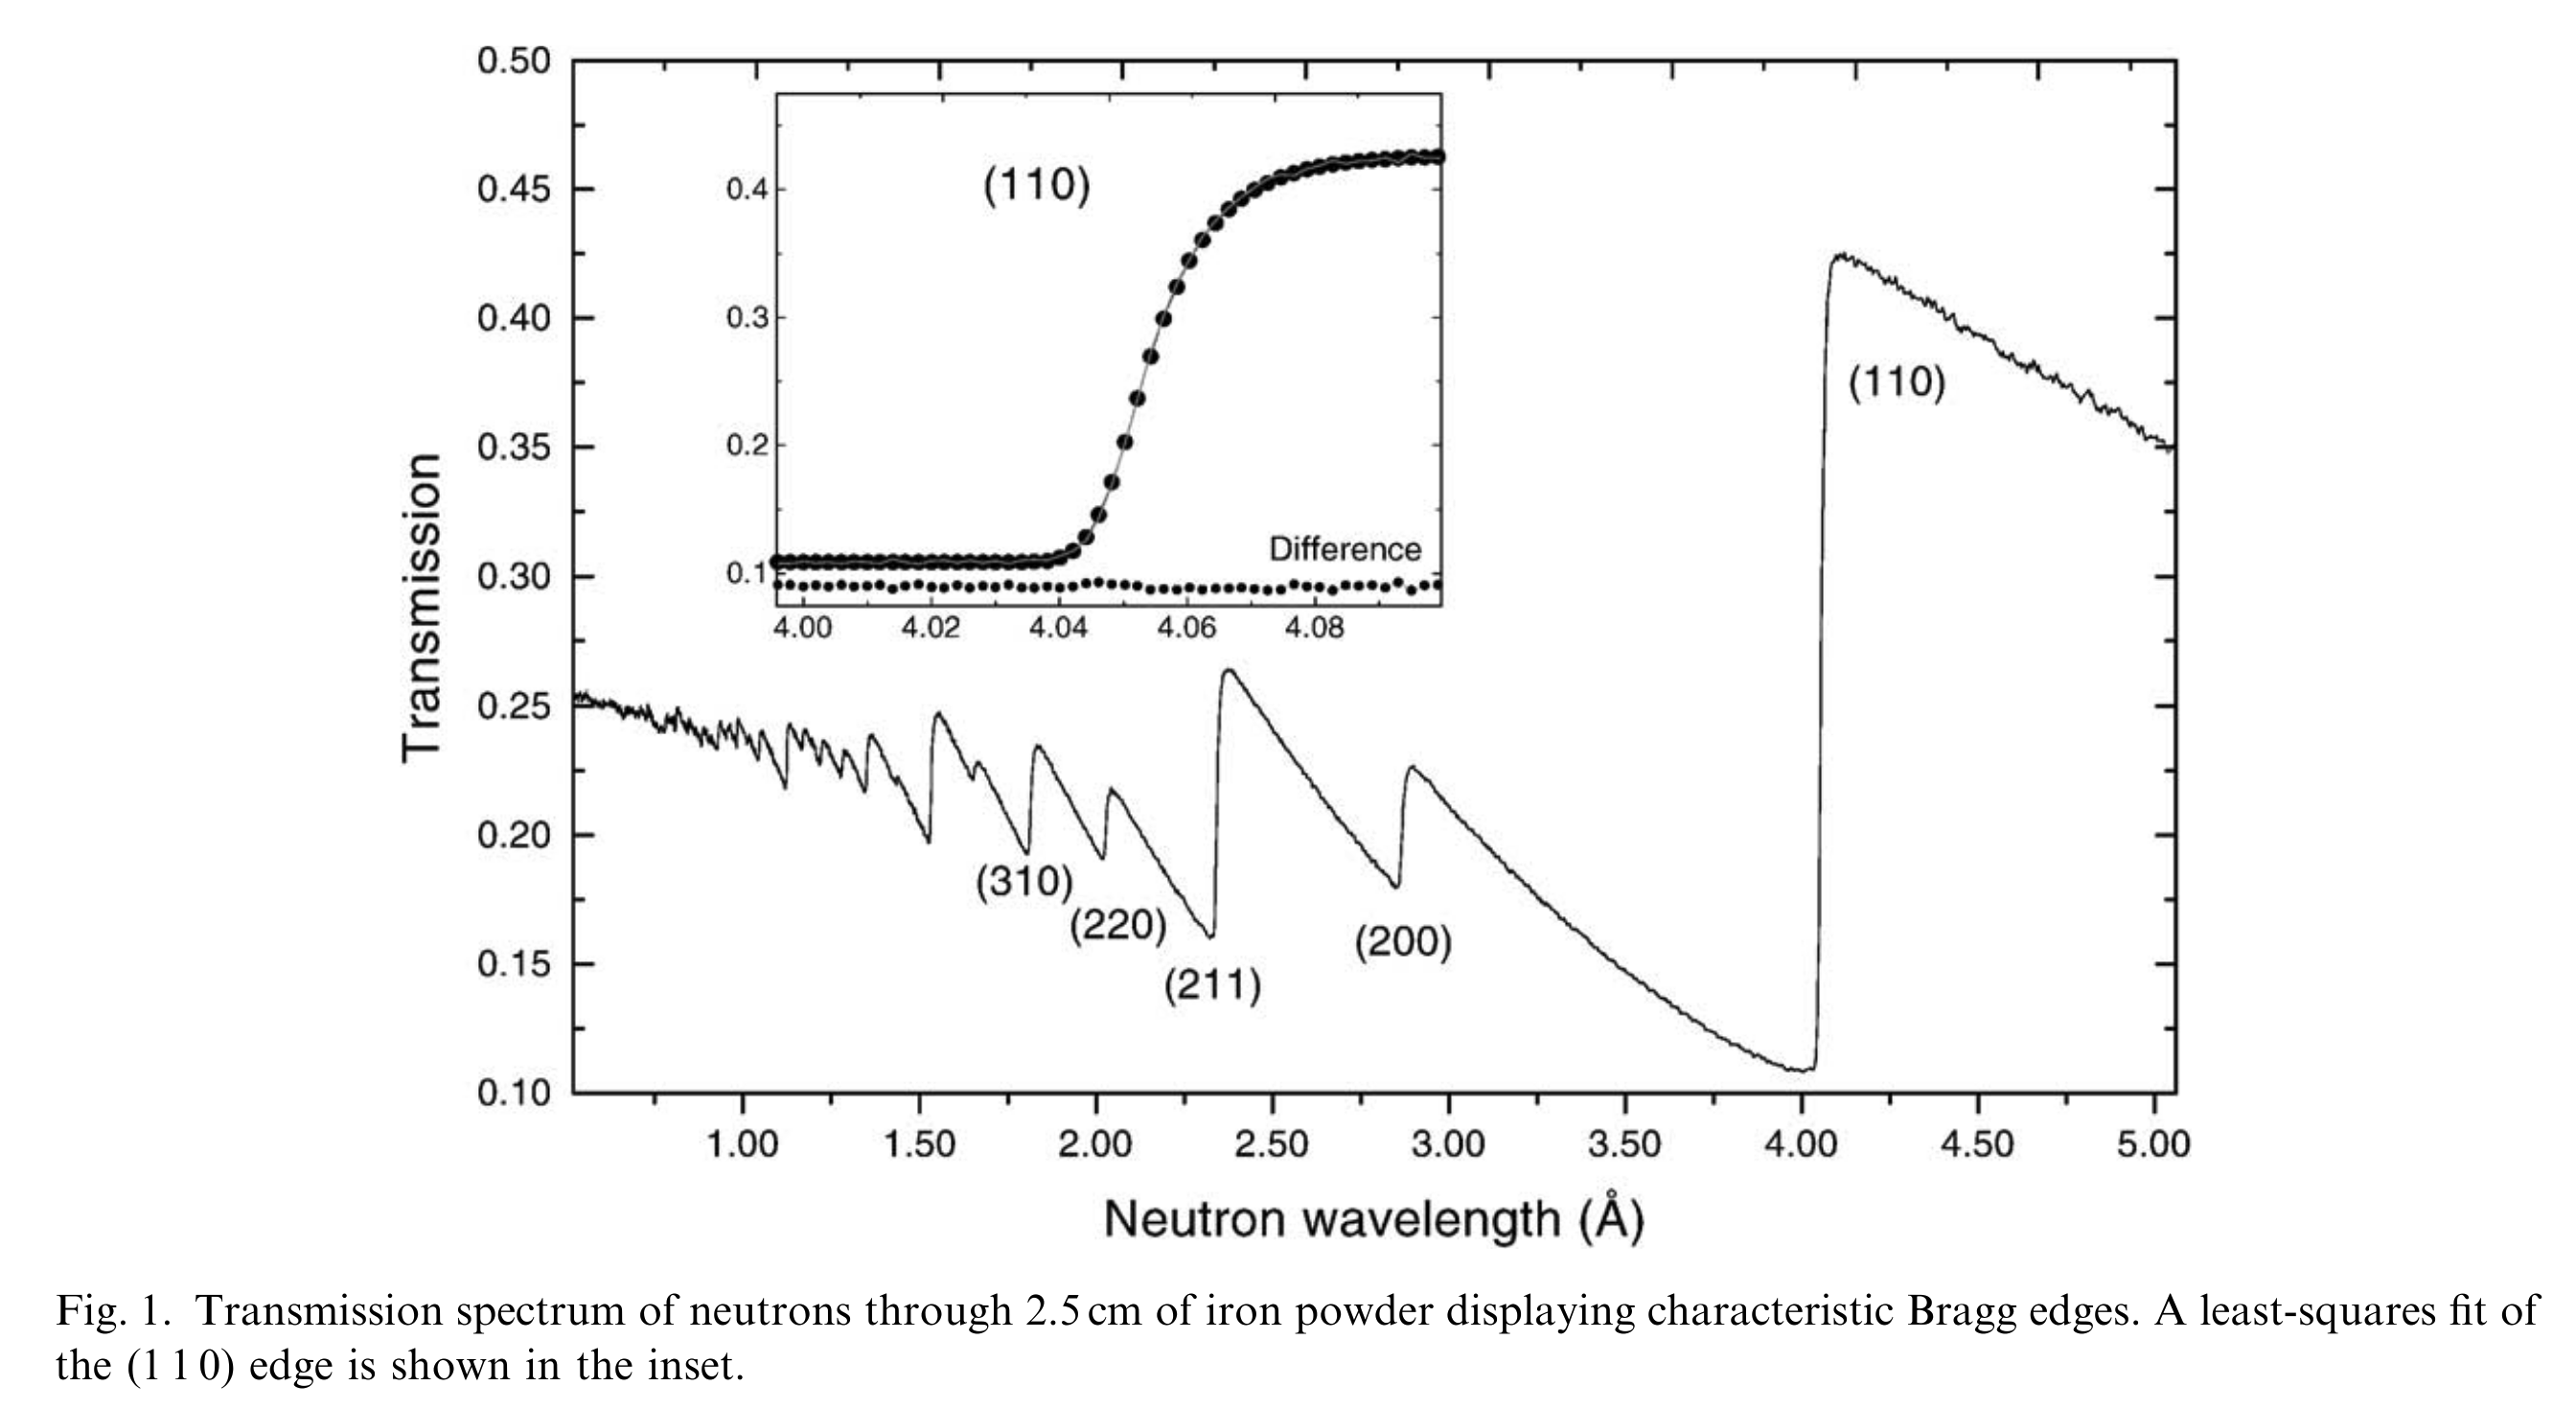

### Physics-Based Attenuation Model

The Santisteban model describes neutron transmission through a material using a physics-based attenuation model.
The attenuation factor is given by the equation:

- Atomic density ($atoms/cm^3$)

- Sample thickness ($cm$)

- Cross-section ($cm^2$)

In [ ]:
def get_attenuation_factor(
    atomic_density: float,
    sample_thickness: float,
    cross_section: float,
) -> float:
    """
    Calculate the attenuation factor for a sample with given cross-section.

    Parameters
    ----------
    atomic_density : float
        The atomic density of the sample in atoms per cubic centimeter.
    sample_thickness : float
        The thickness of the sample in centimeters.
    cross_section : float
        The corresponding cross section of the sample in square centimeters.

    Returns
    -------
    float
        The attenuation factor.
    """
    return np.exp(- atomic_density * sample_thickness * cross_section)

In [3]:
# test with Iron
atomic_density_fe = 8.48e22  # Atomic density, atoms/cm^3
sample_thickness_fe = 1  # Sample thickness, cm
total_cross_section_fe = 11.62e-24  # Total cross-section at long-wavelength side, cm^2
bragg_cross_section_110_fe = 8e-24  # Bragg cross-section for (110) plane, cm^2

background_attenuation_fe = get_attenuation_factor(
    atomic_density_fe,
    sample_thickness_fe,
    total_cross_section_fe,
)
bragg_attenuation_fe = get_attenuation_factor(
    atomic_density_fe,
    sample_thickness_fe,
    bragg_cross_section_110_fe,
)

print(f"Background attenuation factor: {background_attenuation_fe}")
print(f"Bragg attenuation factor: {bragg_attenuation_fe}")

Background attenuation factor: 0.3732988401816966
Bragg attenuation factor: 0.5074282283691137


### Phenomenological Peak Shape Function

The Santisteban model also introduces a phenomenological peak shape function to describe the broadening of the Bragg edge.
This broadening accounts for both instrumental effects and the properties of the sample.

In [4]:
def bragg_edge_func(
    wavelength: np.ndarray,
    bragg_peak_wavelength: float,
    symmetric_broadening: float,
    asymmetric_broadening: float,
) -> np.ndarray:
    """
    Calculate the peak broadening function.

    Parameters
    ----------
    wavelength : np.ndarray
        The wavelength values to calculate the function.
    bragg_peak_wavelength : float
        The wavelength of the Bragg peak.
    symmetric_broadening : float
        The symmetric broadening of the peak.
    asymmetric_broadening : float
        The asymmetric broadening of the peak.

    Returns
    -------
    np.ndarray
        The peak broadening function.
    """
    delta_wavelength = wavelength - bragg_peak_wavelength
    broadening_ratio = symmetric_broadening / asymmetric_broadening

    part1 = special.erfc(- delta_wavelength / (np.sqrt(2)* symmetric_broadening))
    part2 = np.exp(- delta_wavelength/ asymmetric_broadening + broadening_ratio**2/2)
    part3 = special.erfc(- delta_wavelength / (np.sqrt(2)* symmetric_broadening) + broadening_ratio)

    return 0.5 * (part1 - part2 * part3)

Text(0.5, 1.0, 'Bragg Edge function for Iron')

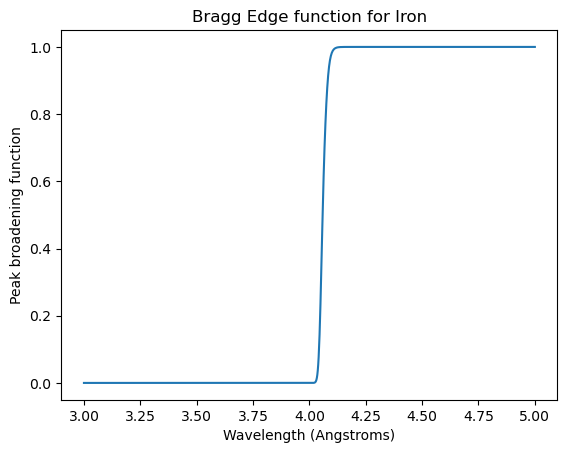

In [6]:
# test with Iron
wavelength = np.linspace(3.0, 5.0, 1000)  # Wavelength values, Angstroms
bragg_peak_wavelength_fe = 4.054  # Wavelength of the Bragg edge, Angstroms
symmetric_broadening_fe = 1e-2  # Symmetric broadening, Angstroms
asymmetric_broadening_fe = 1e-2  # Asymmetric broadening, Angstroms

peak_broadening_fe = bragg_edge_func(
    wavelength,
    bragg_peak_wavelength_fe,
    symmetric_broadening_fe,
    asymmetric_broadening_fe,
)

plt.plot(wavelength, peak_broadening_fe)
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Peak broadening function")
plt.title("Bragg Edge function for Iron")

#### Effect of Symmetric and Asymmetric Broadening

- Symmetric Broadening:
Vary the value of  to show its effect on the peak shape.
Overlay multiple plots to demonstrate how increasing or decreasing symmetric broadening affects the width and sharpness of the Bragg edge.

- Asymmetric Broadening:
Similarly, vary the value of  to show its effect on the asymmetry of the peak.
Overlay plots to illustrate how a smaller or larger asymmetric parameter changes the tail of the Bragg edge.

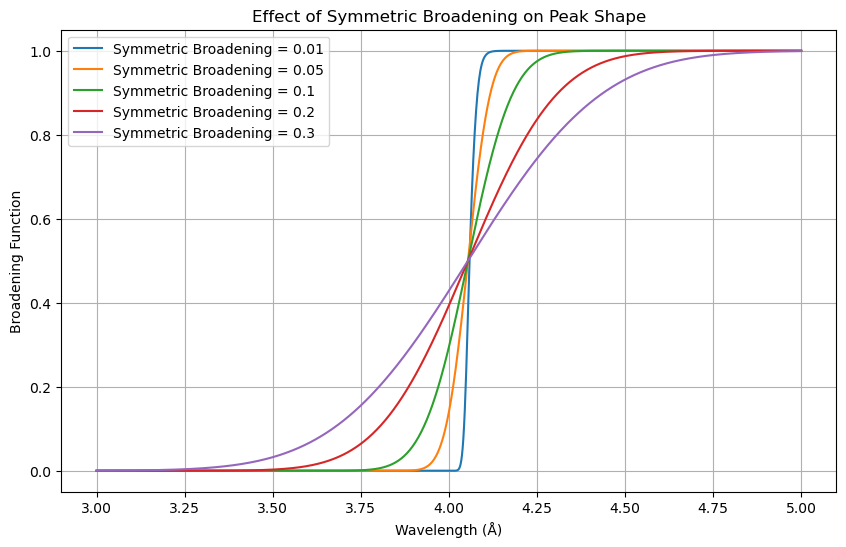

In [10]:
# Demonstrating the effect of symmetric broadening
plt.figure(figsize=(10, 6))
for sigma in [0.01, 0.05, 0.1, 0.2, 0.3]:
    peak_broadening = bragg_edge_func(wavelength, bragg_peak_wavelength_fe, sigma, asymmetric_broadening_fe)
    plt.plot(wavelength, peak_broadening, label=f'Symmetric Broadening = {sigma}')

plt.xlabel('Wavelength (Å)')
plt.ylabel('Broadening Function')
plt.title('Effect of Symmetric Broadening on Peak Shape')
plt.legend()
plt.grid(True)
plt.show()

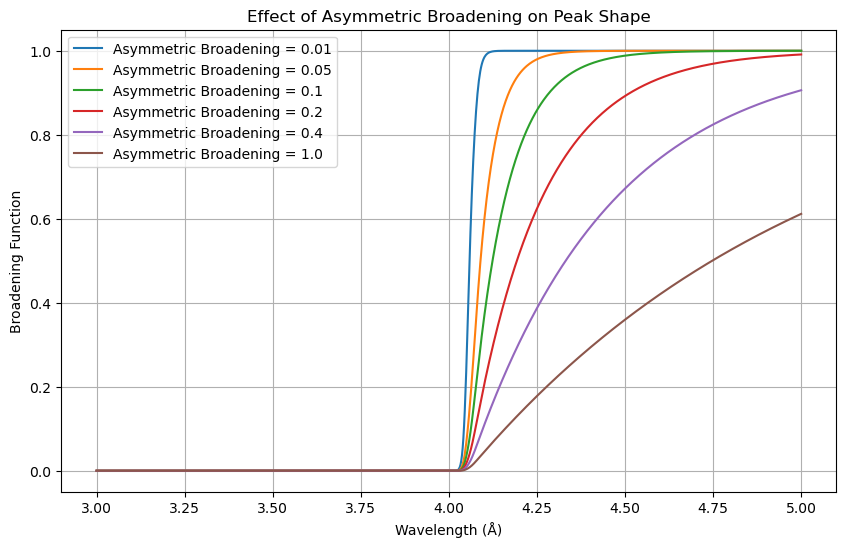

In [12]:
# Demonstrating the effect of asymmetric broadening
plt.figure(figsize=(10, 6))
for tau in [0.01, 0.05, 0.1, 0.2, 0.4, 1.0]:
    peak_broadening = bragg_edge_func(wavelength, bragg_peak_wavelength_fe, symmetric_broadening_fe, tau)
    plt.plot(wavelength, peak_broadening, label=f'Asymmetric Broadening = {tau}')

plt.xlabel('Wavelength (Å)')
plt.ylabel('Broadening Function')
plt.title('Effect of Asymmetric Broadening on Peak Shape')
plt.legend()
plt.grid(True)
plt.show()

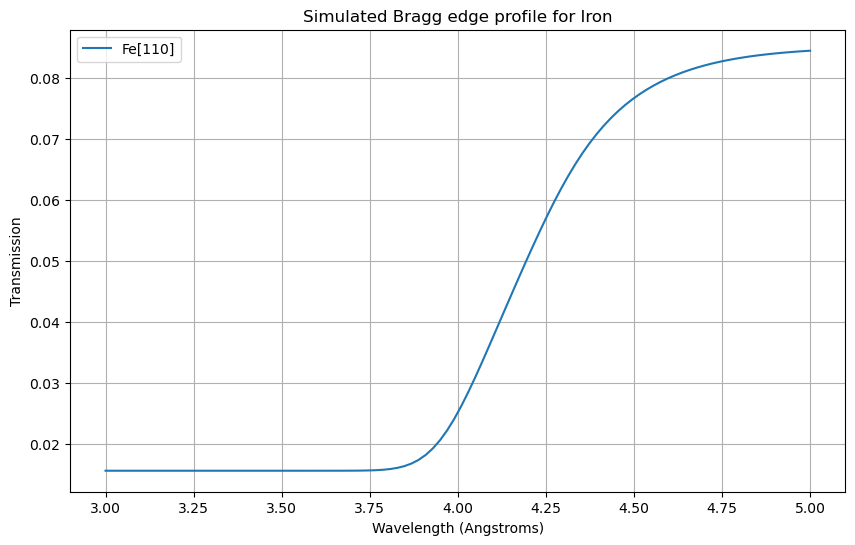

In [4]:
def simulate_bragg_edge(
    wavelengths: np.ndarray,
    atomic_density: float,
    sample_thickness: float,
    total_cross_section: float,
    bragg_cross_section: float,
    bragg_wavelength: float,
    symmetric_broadening_param: float,
    asymmetric_broadening_param: float,
) -> np.ndarray:
    """
    Simulate the Bragg edge profile.

    Parameters
    ----------
    wavelengths : np.ndarray
        The wavelength values to calculate the Bragg edge profile.
    atomic_density : float
        The atomic density of the sample in atoms per cubic centimeter.
    sample_thickness : float
        The thickness of the sample in centimeters.
    total_cross_section : float
        The total cross-section at long-wavelength side, in square centimeters.
    bragg_cross_section : float
        The Bragg cross-section for HKL plane, in square centimeters.
    bragg_wavelength : float
        The wavelength of the Bragg peak.
    symmetric_broadening_param : float
        The symmetric broadening parameter.
    asymmetric_broadening_param : float
        The asymmetric broadening parameter.

    Returns
    -------
    np.ndarray
        The simulated Bragg edge profile.
    """
    background_attenuation = get_attenuation_factor(
        atomic_density,
        sample_thickness,
        total_cross_section,
    )
    bragg_attenuation = get_attenuation_factor(
        atomic_density,
        sample_thickness,
        bragg_cross_section,
    )

    peak_broadening = bragg_edge_func(
        wavelengths,
        bragg_wavelength,
        symmetric_broadening_param,
        asymmetric_broadening_param,
    )

    return background_attenuation * ( bragg_attenuation + (1 - bragg_attenuation)* peak_broadening)


# test with Iron
wavelengths_fe = np.linspace(3.0, 5.0, 100)  # Wavelength values, Angstroms
atomic_density_fe = 8.48e22  # Atomic density, atoms/cm^3
sample_thickness_fe = 2.5  # Sample thickness, cm
total_cross_section_fe = 11.62e-24  # Total cross-section at long-wavelength side, cm^2
bragg_cross_section_110_fe = 8e-24  # Bragg cross-section for (110) plane, cm^2
bragg_peak_wavelength_fe = 4.054  # Wavelength of the Bragg edge, Angstroms
symmetric_broadening_fe = 0.1  # Symmetric broadening, Angstroms
asymmetric_broadening_fe = 0.2  # Asymmetric broadening, Angstroms

bragg_edge_fe = simulate_bragg_edge(
    wavelengths_fe,
    atomic_density_fe,
    sample_thickness_fe,
    total_cross_section_fe,
    bragg_cross_section_110_fe,
    bragg_peak_wavelength_fe,
    symmetric_broadening_fe,
    asymmetric_broadening_fe,
)

plt.figure(figsize=(10, 6))
plt.plot(wavelengths_fe, bragg_edge_fe, label="Fe[110]")
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Transmission")
plt.title("Simulated Bragg edge profile for Iron")
plt.legend()
plt.grid(True)
plt.show()

Let's see if we can simulate a transmission spectrum with a Bragg Edge in it.

Text(0.5, 1.0, 'High-wavelength side transmission function for Iron')

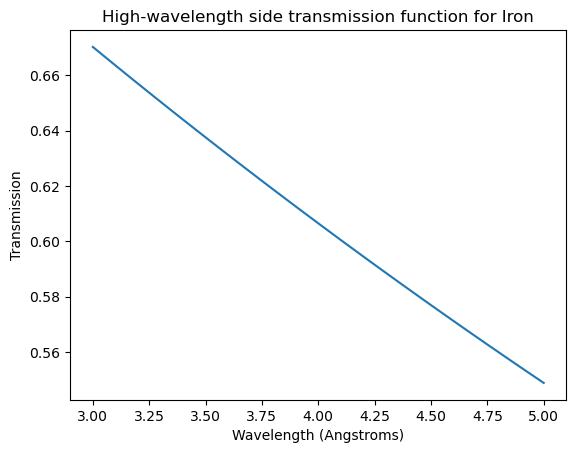

In [5]:
def kropff_high_lambda_tranmission(
    wavelength: np.ndarray,
    a0: float,
    b0: float,
) -> np.ndarray:
    """
    Calculate the high-wavelength side transmission function.

    Parameters
    ----------
    wavelength : np.ndarray
        The wavelength values to calculate the function.
    a0 : float
        The a0 parameter.
    b0 : float
        The b0 parameter.

    Returns
    -------
    np.ndarray
        The high-wavelength side transmission function.
    """
    return np.exp(- (a0 + b0 * wavelength))

# test with Iron
wavelengths_fe = np.linspace(3.0, 5.0, 100)  # Wavelength values, Angstroms
a0_fe = 0.1  # a0 parameter
b0_fe = 0.1  # b0 parameter

high_lambda_transmission_fe = kropff_high_lambda_tranmission(
    wavelengths_fe,
    a0_fe,
    b0_fe,
)

plt.plot(wavelengths_fe, high_lambda_transmission_fe)
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Transmission")
plt.title("High-wavelength side transmission function for Iron")

Text(0.5, 1.0, 'Low-wavelength side transmission function for Iron')

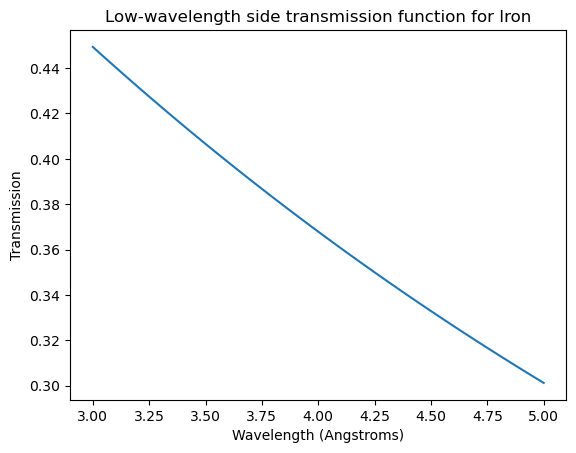

In [6]:
def kropff_low_lambda_transmission(
    wavelength: np.ndarray,
    a0: float,
    b0: float,
    a_hkl: float,
    b_hkl: float,
) -> np.ndarray:
    """
    Calculate the low-wavelength side transmission function.

    Parameters
    ----------
    wavelength : np.ndarray
        The wavelength values to calculate the function.
    a0 : float
        The a0 parameter.
    b0 : float
        The b0 parameter.
    a_hkl : float
        The a_HKL parameter.
    b_hkl : float
        The b_HKL parameter.

    Returns
    -------
    np.ndarray
        The low-wavelength side transmission function.
    """
    return np.exp(- (a0 + b0 * wavelength) - (a_hkl + b_hkl * wavelength))

# test with Iron
wavelengths_fe = np.linspace(3.0, 5.0, 100)  # Wavelength values, Angstroms
a0_fe = 0.1  # a0 parameter
b0_fe = 0.1  # b0 parameter
a_hkl_fe = 0.1  # a_HKL parameter
b_hkl_fe = 0.1  # b_HKL parameter

low_lambda_transmission_fe = kropff_low_lambda_transmission(
    wavelengths_fe,
    a0_fe,
    b0_fe,
    a_hkl_fe,
    b_hkl_fe,
)

plt.plot(wavelengths_fe, low_lambda_transmission_fe)
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Transmission")
plt.title("Low-wavelength side transmission function for Iron")


In [9]:
def simulate_tranmission_with_bragg_edge(
    wavelengths: np.ndarray,
    a0: float,
    b0: float,
    a_hkl: float,
    b_hkl: float,
    bragg_wavelegnth: float,
    symmetric_broadening_param: float,
    asymmetric_broadening_param: float,
) -> np.ndarray:
    """
    Simulate the transmission profile with Bragg edge.

    Parameters
    ----------
    wavelengths : np.ndarray
        The wavelength values to calculate the transmission profile.
    a0 : float
        The a0 parameter.
    b0 : float
        The b0 parameter.
    a_hkl : float
        The a_HKL parameter.
    b_hkl : float
        The b_HKL parameter.
    bragg_wavelegnth : float
        The wavelength of the Bragg peak.
    symmetric_broadening_param : float
        The symmetric broadening parameter.
    asymmetric_broadening_param : float
        The asymmetric broadening parameter.

    Returns
    -------
    np.ndarray
        The simulated transmission profile.
    """
    high_lambda_transmission = kropff_high_lambda_tranmission(
        wavelengths,
        a0,
        b0,
    )

    low_lambda_transmission = kropff_low_lambda_transmission(
        wavelengths,
        a0,
        b0,
        a_hkl,
        b_hkl,
    )

    peak_broadening = bragg_edge_func(
        wavelengths,
        bragg_wavelegnth,
        symmetric_broadening_param,
        asymmetric_broadening_param,
    )

    transmission_spectrum = high_lambda_transmission * (low_lambda_transmission + (1 - low_lambda_transmission) * peak_broadening)

    return transmission_spectrum

# test with Iron
wavelengths_fe = np.linspace(3.0, 5.0, 100)  # Wavelength values, Angstroms
a0_fe = 0.1  # a0 parameter
b0_fe = 0.1  # b0 parameter
a_hkl_fe = 0.1  # a_HKL parameter
b_hkl_fe = 0.1  # b_HKL parameter
bragg_peak_wavelength_fe = 4.054  # Wavelength of the Bragg edge, Angstroms

symmetric_broadening_fe = 0.1  # Symmetric broadening, Angstroms
asymmetric_broadening_fe = 0.2  # Asymmetric broadening, Angstroms

transmission_fe = simulate_tranmission_with_bragg_edge(
    wavelengths_fe,
    a0_fe,
    b0_fe,
    a_hkl_fe,
    b_hkl_fe,
    bragg_peak_wavelength_fe,
    symmetric_broadening_fe,
    asymmetric_broadening_fe,
)

# compute the Bragg edge profile for comparison
bragg_edge_fe = simulate_bragg_edge(
    wavelengths_fe,
    atomic_density_fe,
    sample_thickness_fe,
    total_cross_section_fe,
    bragg_cross_section_110_fe,
    bragg_peak_wavelength_fe,
    symmetric_broadening_fe,
    asymmetric_broadening_fe,
)

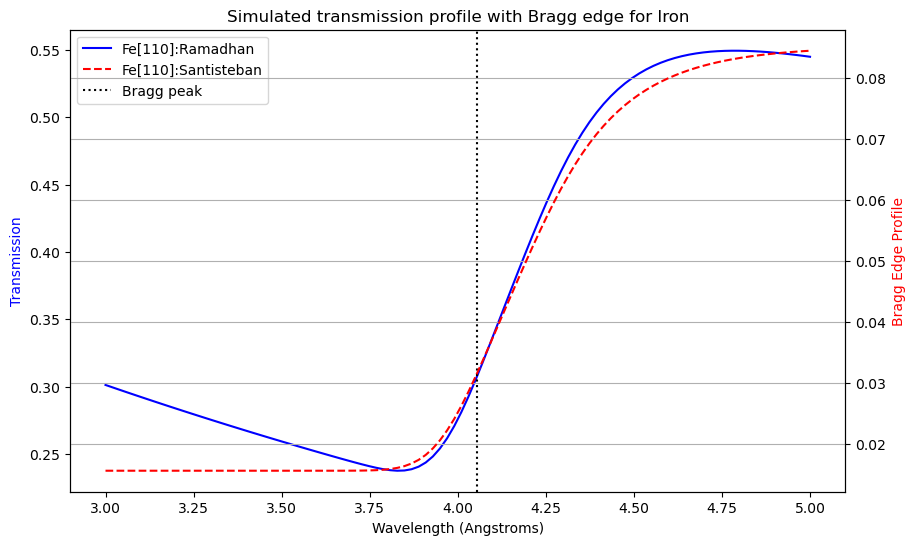

In [10]:
plt.figure(figsize=(10, 6))

# Create the first axis
ax1 = plt.gca()

# Plot the simulated transmission profile on the first axis
line1 = ax1.plot(wavelengths_fe, transmission_fe, label="Fe[110]:Ramadhan", color='b')

# Create a second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the Bragg edge profile on the second axis
line2 = ax2.plot(wavelengths_fe, bragg_edge_fe, 'r--', label="Fe[110]:Santisteban")

# Add vertical line for Bragg peak
line3 = ax1.axvline(x=bragg_peak_wavelength_fe, color='k', linestyle=':', label="Bragg peak")

# Set labels and title
ax1.set_xlabel("Wavelength (Angstroms)")
ax1.set_ylabel("Transmission", color='b')
ax2.set_ylabel("Bragg Edge Profile", color='r')
plt.title("Simulated transmission profile with Bragg edge for Iron")

# Combine legends from both axes
lines = line1 + line2 + [line3]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

# Show the plot
plt.grid(True)
plt.show()
